# Visualize quantile and parametric forecasts

In [3]:
# imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from create_parametric_forecasts import ParametricForecasts
import re
import scipy
import sys

In [2]:
# Specify the forecast to investigate
#path_quantile = 'C:\\Users\\fh6281\\PycharmProjects\\GermanBuildingDate\\02_forecast\\storage_quantile_fc\\file_fc_PatchTST_SFH3_2025-07-16_13-47-24_freq15.csv'

#path_quantile = 'C:\\Users\\fh6281\\PycharmProjects\\GermanBuildingDate\\02_forecast\\storage_quantile_fc\\file_fc_AutoKAN_SFH3_2025-07-25_14-18-05_freq15.csv'  # Big thingy
path_quantile = 'C:\\Users\\fh6281\\PycharmProjects\\GermanBuildingDate\\02_forecast\\storage_quantile_fc\\file_fc_AutoKAN_SFH3_short.csv'                      # Short version of the big thingy

# get the corresponding path to the parametric forecast
path_parametric = path_quantile.replace('storage_quantile_fc', 'storage_param_fc').replace('file_fc_', 'file_fc_parametric_')

In [4]:
# Define visualization functions
def plot_specific_day(df_fc, df_gt, time, title=None, single_index=False):

    if not single_index:
        fc_time = df_fc.loc[time]
    else:
        fc_time = df_fc
    #gt_time = df_gt.loc[time]

    fig = go.Figure()
    for col in fc_time.columns:
        fig.add_trace(go.Scatter(x=fc_time.index, y=fc_time[col], mode='lines', name=col))
    fig.add_trace(go.Scatter(x=fc_time.index, y=df_gt.loc[fc_time.index, 'P_TOT'], mode='lines', name='Ground Truth', line=dict(color='black', width=4)))
    fig.update_layout(title=title if title else f'Forecast for {time}', xaxis_title='Time', yaxis_title='Value')
    fig.show()

## Quantile Forecasts

In [7]:
# Load the quantile forecasts
fc_quantile = pd.read_csv(path_quantile, index_col=[0,1], parse_dates=True)


gt = fc_quantile['P_TOT'].reset_index()
gt.index = gt['timestamp']
gt_in_fc_format = gt.copy().set_index(['time_fc_created', 'timestamp'])
gt = gt.drop(columns=['timestamp', 'time_fc_created'])
gt = gt[~gt.index.duplicated(keep='first')]

# Drop the building and P-TOT columns from the quantile forecast
fc_quantile = fc_quantile.drop(columns=['P_TOT'])

In [8]:
time_to_plot = '2020-05-13 08:00:00'
plot_specific_day(fc_quantile, gt, time_to_plot, title=f'Unsorted Quantile Forecast for {time_to_plot}')

In [9]:
pf = ParametricForecasts()
pf.load_quantile_forecasts(path_quantile)

fc_quantile_sorted = pf.sort_quantiles()
plot_specific_day(fc_quantile_sorted, gt, time_to_plot, title=f'Sorted Quantile Forecast for {time_to_plot}')

Sorting quantiles in ascending order…


In [10]:
fc_quantile_smoothed_over_time = pf.smooth_quantiles_over_time(fc_quantile_sorted, window_size=5)
plot_specific_day(fc_quantile_smoothed_over_time, gt, time_to_plot, title=f'Smoothed Quantile Forecast for {time_to_plot}')

Smoothing each quantile over time with a rolling mean…


In [11]:
fc_quantile_smoothed = pf.smooth_quantiles_at_each_time(fc_quantile_sorted, window_size=5)
plot_specific_day(fc_quantile_smoothed, gt, time_to_plot, title=f'Smoothed Quantile Forecast at Each Time for {time_to_plot}')

Smoothing all quantiles at each time with a rolling mean…


## Parametric Forecasts

In [5]:
pf = ParametricForecasts()
fc_param = pf.load_parametric_forecasts(path_parametric)
pf.compute_expected_values(fc_param, name='sum2gaussian')

w1          mu1  \
time_fc_created           timestamp                                          
2020-05-13 06:15:00+00:00 2020-05-13 06:15:00+00:00  0.600381  -917.405019   
                          2020-05-13 06:30:00+00:00  0.884938 -1151.550752   
                          2020-05-13 06:45:00+00:00  0.297729  -933.274690   
                          2020-05-13 07:00:00+00:00  0.373194 -1054.012194   
                          2020-05-13 07:15:00+00:00  0.465347 -1302.621496   
...                                                       ...          ...   
2020-05-14 06:30:00+00:00 2020-05-15 06:15:00+00:00  0.237718  -776.002835   
2020-05-14 06:45:00+00:00 2020-05-14 06:45:00+00:00  0.744643 -2439.871092   
                          2020-05-14 07:00:00+00:00  0.302055 -1480.672800   
                          2020-05-14 07:15:00+00:00  0.315221 -1531.756255   
                          2020-05-14 07:30:00+00:00  0.635609 -3336.097725   

                                                            std1        w2  \
time_fc_created           timestamp                                          
2020-05-13 06:15:00+00:00 2020-05-13 06:15:00+00:00   389.627821  0.399619   
                          2020-05-13 06:30:00+00:00   617.161790  0.115062   
                          2020-05-13 06:45:00+00:00  1383.837233  0.702271   
                          2020-05-13 07:00:00+00:00  1380.738604  0.626806   
                          2020-05-13 07:15:00+00:00  1356.399708  0.534653   
...                                                          ...       ...   
2020-05-14 06:30:00+00:00 2020-05-15 06:15:00+00:00  1659.823723  0.762282   
2020-05-14 06:45:00+00:00 2020-05-14 06:45:00+00:00   628.075400  0.255357   
                          2020-05-14 07:00:00+00:00  1721.562038  0.697945   
                          2020-05-14 07:15:00+00:00  1635.221060  0.684779   
                          2020-05-14 07:30:00+00:00   981.766578  0.364391   

                                                             mu2         std2  \
time_fc_created           timestamp                                             
2020-05-13 06:15:00+00:00 2020-05-13 06:15:00+00:00  -759.903605   956.698442   
                          2020-05-13 06:30:00+00:00    75.561631  1395.295839   
                          2020-05-13 06:45:00+00:00 -1258.773808   595.880110   
                          2020-05-13 07:00:00+00:00 -1555.810991   767.658216   
                          2020-05-13 07:15:00+00:00 -1705.074867   822.937399   
...                                                          ...          ...   
2020-05-14 06:30:00+00:00 2020-05-15 06:15:00+00:00 -1380.577791   773.714970   
2020-05-14 06:45:00+00:00 2020-05-14 06:45:00+00:00 -1997.426607  1610.889403   
                          2020-05-14 07:00:00+00:00 -2784.807058   843.187195   
                          2020-05-14 07:15:00+00:00 -3174.831085   821.308985   
                          2020-05-14 07:30:00+00:00 -2101.743677  1872.227756   

                                                     expected_value  
time_fc_created           timestamp                                  
2020-05-13 06:15:00+00:00 2020-05-13 06:15:00+00:00     -854.464533  
                          2020-05-13 06:30:00+00:00    -1010.357244  
                          2020-05-13 06:45:00+00:00    -1161.863168  
                          2020-05-13 07:00:00+00:00    -1368.542597  
                          2020-05-13 07:15:00+00:00    -1517.794590  
...                                                             ...  
2020-05-14 06:30:00+00:00 2020-05-15 06:15:00+00:00    -1236.859622  
2020-05-14 06:45:00+00:00 2020-05-14 06:45:00+00:00    -2326.889865  
                          2020-05-14 07:00:00+00:00    -2390.886150  
                          2020-05-14 07:15:00+00:00    -2656.899454  
                          2020-05-14 07:30:00+00:00    -2886.310824  

[9412 rows x 7 columns]

In [12]:
timestamp = pd.Timestamp('2020-05-13 06:15:00', tz='UTC')
#fc_param.loc[timestamp, 'expected_value'].plot()
plot_specific_day(fc_param.loc[:, ['expected_value']], gt, timestamp, title=f'Expected Value for {timestamp}')

In [13]:
# Create a dataframe based on the expected values. Only take the first entry for each time_fc_creation
fc_param_expected_next_step = fc_param.loc[:, ['expected_value']].reset_index()
fc_param_expected_next_step = fc_param_expected_next_step[~fc_param_expected_next_step['time_fc_created'].duplicated(keep='first')]
fc_param_expected_next_step.set_index('timestamp', inplace=True)
fc_param_expected_next_step
plot_specific_day(fc_param_expected_next_step.loc[:, ['expected_value']], gt, timestamp, title=f'Only Upcoming FC vs Ground Truth', single_index=True)

In [13]:
# TODO: Plot single hour PDFS
# TODO: Compare single hour fitted PDFs and CDFs with the quantile forecasts

# TODO: Visualize PIT-Plots for the quantile forecasts

In [14]:
import math
from typing import Iterable, Tuple, Sequence, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm


def plot_cdf_comparison(
    fc_quantile: pd.DataFrame,
    fc_param: pd.DataFrame,
    gt: pd.Series,
    issuance_time: pd.Timestamp,
    target_range: Tuple[pd.Timestamp, pd.Timestamp],
    *,
    max_panels: int = 12,
    quantile_regex: str = r"quantile_(\d+(?:\.\d+)?)",  # columns like q0.05, q0.5 …
    figsize_per_panel: Tuple[float, float] = (4.0, 3.0),
):
    """
    Compare the CDF of a quantile forecast and a parametric (two-Gaussian) forecast.

    Parameters
    ----------
    fc_quantile, fc_param
        Multi-index DataFrames. Level-0 index = forecast creation time,
        level-1 index = target timestamp.  `fc_quantile` columns are quantiles,
        e.g. 'q0.05', 'q0.5', …  `fc_param` columns are the 6 mixture parameters
        (w1, mu1, sigma1, w2, mu2, sigma2).
    gt
        Pandas Series indexed by timestamp with the realised value.
    issuance_time
        Timestamp of the issuance to visualise (must exist in level-0 index).
    target_range
        (start_ts, end_ts) limiting the targets to plot.
    max_panels
        If more targets than `max_panels`, plot a regular subsample.
    quantile_regex
        Regex for extracting the numerical α from column names.
    param_cols
        Ordered names of the 6 mixture columns.
    figsize_per_panel
        Size of each subplot in inches.
    """
    # --------------------
    # 1. Slice the inputs
    # --------------------
    q_slice = (
        fc_quantile.loc[issuance_time]
        .sort_index()
        .loc[target_range[0] : target_range[1]]
    )
    p_slice = (
        fc_param.loc[issuance_time]
        .sort_index()
        .loc[target_range[0] : target_range[1]]
    )
    gt_slice = gt.loc[target_range[0] : target_range[1]]

    if q_slice.empty:
        raise ValueError("No quantile data after slicing – check your indices.")
    if p_slice.empty:
        raise ValueError("No parametric data after slicing – check your indices.")

    # Limit number of sub-plots
    targets = q_slice.index
    if len(targets) > max_panels:
        step = math.ceil(len(targets) / max_panels)
        targets = targets[::step]

    # Extract α’s from quantile columns (e.g. 'q0.15' -> 0.15)
    quantile_levels = (
        pd.Series(q_slice.columns)
        .str.extract(quantile_regex, expand=False)
        .astype(float)
        .values
    )

    # --------------------
    # 2. Build figure
    # --------------------
    n_panels = len(targets)
    n_cols = min(3, n_panels)
    n_rows = math.ceil(n_panels / n_cols)
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(figsize_per_panel[0] * n_cols, figsize_per_panel[1] * n_rows),
        squeeze=False,
    )

    for ax, t in zip(axes.flat, targets):
        # Quantile forecast → empirical CDF (piece-wise linear)
        q_vals = q_slice.loc[t].values.astype(float)
        # Ensure sorted order just in case
        x_q = np.sort(q_vals)
        alpha = quantile_levels
        # Add 0 and 1 boundaries for proper CDF plot
        x_q = np.concatenate(([x_q[0]], x_q, [x_q[-1]]))
        alpha = np.concatenate(([0.0], alpha, [1.0]))
        ax.plot(x_q, alpha, drawstyle="steps-post", label="quantile-CDF")
        

        w1 = p_slice.loc[t, "w1"]
        mu1 = p_slice.loc[t, "mu1"]
        sigma1 = p_slice.loc[t, "std1"]
        w2 = p_slice.loc[t, "w2"]
        mu2 = p_slice.loc[t, "mu2"]
        sigma2 = p_slice.loc[t, "std2"]
        x_min = min(np.min(x_q), mu1 - 4 * sigma1, mu2 - 4 * sigma2)
        x_max = max(np.max(x_q), mu1 + 4 * sigma1, mu2 + 4 * sigma2)
        x_grid = np.linspace(x_min, x_max, 400)
        cdf_mix = w1 * norm.cdf(x_grid, mu1, sigma1) + w2 * norm.cdf(
            x_grid, mu2, sigma2
        )
        ax.plot(x_grid, cdf_mix, label="parametric-CDF")

        # Plot a vertical line for the ground truth value
        if t in gt_slice.index:
            ax.axvline(
                gt_slice.loc[t].values[0],
                color="k",
                lw=1,
                ls="--",
                label="ground-truth" if "ground-truth" not in ax.get_legend_handles_labels()[1] else None,
            )

        ax.set_title(f"{t:%Y-%m-%d %H:%M}")
        ax.set_xlabel("Value")
        ax.set_ylabel("F(x)")
        ax.set_ylim(0, 1)
        ax.grid(True)

    # Hide any empty axes
    for ax in axes.flat[n_panels:]:
        ax.set_visible(False)

    # Single legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    return fig


C:\Users\fh6281\AppData\Local\Temp\ipykernel_19996\3074357829.py:12: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



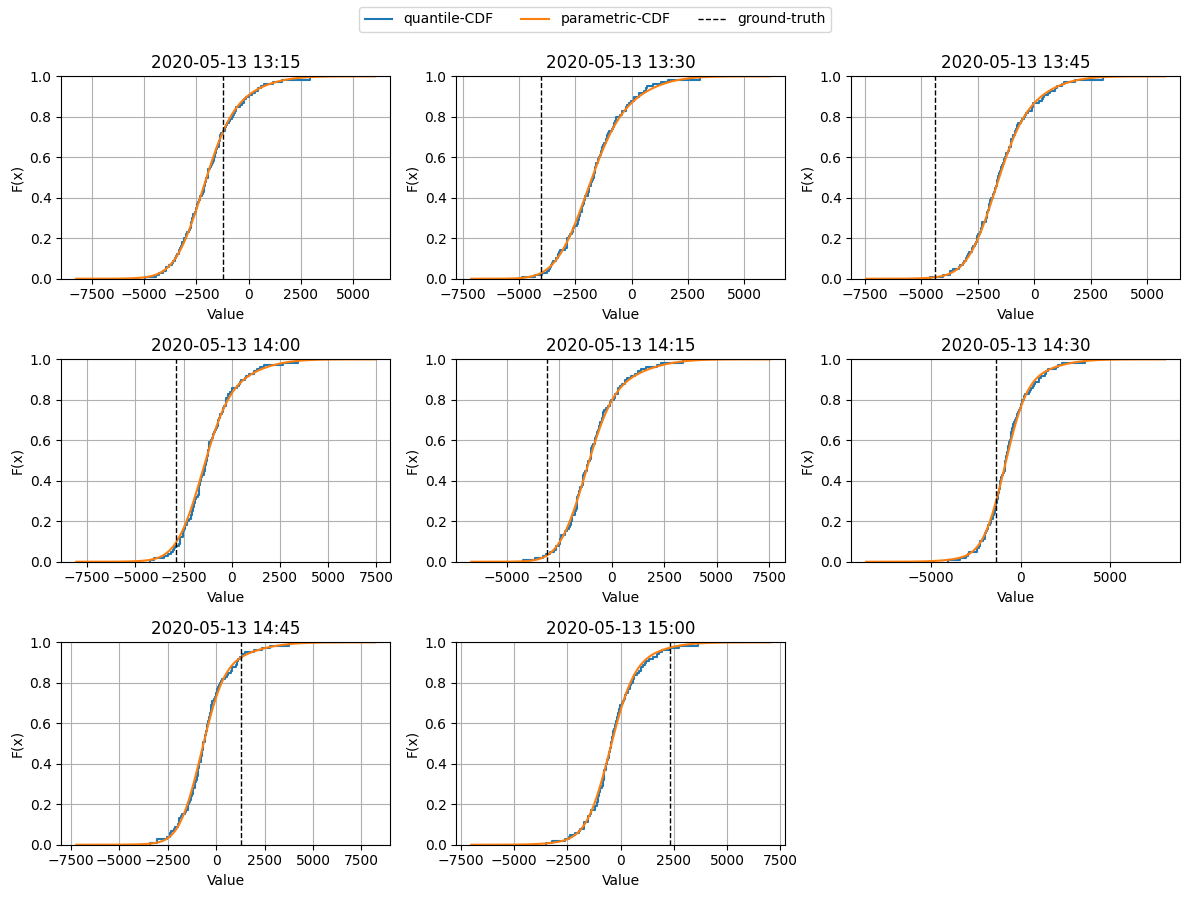

In [15]:
issuance = pd.Timestamp("2020-05-13 13:00", tz="utc")
t_start = issuance + pd.Timedelta(minutes=15)      # first target
t_end   = issuance + pd.Timedelta(hours=2)        # last target

fig = plot_cdf_comparison(
    fc_quantile=fc_quantile,
    fc_param=fc_param,
    gt=gt,
    issuance_time=issuance,
    target_range=(t_start, t_end)
)
fig.show()


In [ ]:
# TODO: Plot the PDFs of a specific hour

## PIT Plots

In [16]:
def interpolate_cdf_val_to_p(fc_df):
    fc_interpolated = []

    total_rows = len(fc_df)
    processed = 0
    last_percent = -1  # to avoid printing too often


    for index, row in fc_df.iterrows():

        y_values = row.values  # Quantile values (ascending)
        p_values = row.index.astype(float)  # Quantile levels (0.01, 0.02, ..., 0.99)

        # Create CDF interpolator (y -> p)
        cdf_interpolator = scipy.interpolate.interp1d(
            y_values, p_values, 
            kind='linear', 
            fill_value=(0.0, 1.0),  # Extrapolate to 0 and 1
            #fill_value='extrapolate', # Extrapolates linearily
            bounds_error=False
        )
        fc_interpolated.append(cdf_interpolator)


        # Progress update (every 1%)
        processed += 1
        percent = int(100 * processed / total_rows)
        if percent != last_percent and percent % 1 == 0:
            print(f"\rProgress: {percent}% ({processed}/{total_rows})", end="")
            sys.stdout.flush()
            last_percent = percent

    return pd.Series(fc_interpolated, index=fc_df.index)

def pit_plot_layout(fig, title = 'PIT Plot'):
    fig.update_layout(
        title=title,
        xaxis_title='PIT Value',
        yaxis_title='Frequency',
        width=1000, 
        height=400
)
    fig.show()
    return None


In [17]:
forecast_interpolated = interpolate_cdf_val_to_p(fc_quantile_sorted)
assert len(forecast_interpolated) == len(gt_in_fc_format), "Forecast and ground truth do not match in length."

Progress: 100% (9412/9412)

In [18]:
summer = ['2020-05-13', '2020-08-31']
fall = ['2020-09-01', '2020-10-30']
winter = ['2020-11-01', '2020-12-30']

daytime = [5, 23]  # 6 AM to 8 PM


pit_full = [cdf_inv(y[0]) for cdf_inv, y in zip(forecast_interpolated, gt_in_fc_format.values)]
pit_summer = [cdf_inv(y[0]) for cdf_inv, y in zip(forecast_interpolated.loc[summer[0]:summer[1]], gt_in_fc_format.loc[summer[0]:summer[1]].values)]
pit_fall = [cdf_inv(y[0]) for cdf_inv, y in zip(forecast_interpolated.loc[fall[0]:fall[1]], gt_in_fc_format.loc[fall[0]:fall[1]].values)]
pit_winter = [cdf_inv(y[0]) for cdf_inv, y in zip(forecast_interpolated.loc[winter[0]:winter[1]], gt_in_fc_format.loc[winter[0]:winter[1]].values)]

# For day/nighttime => the second index is the important one!
hours = forecast_interpolated.index.get_level_values('timestamp').hour
mask_daytime = (hours >= daytime[0]) & (hours <= daytime[1])
mask_night = (hours < daytime[0]) | (hours > daytime[1])

pit_daytime = [cdf_inv(y[0]) for cdf_inv, y in zip(forecast_interpolated.iloc[mask_daytime], gt_in_fc_format.iloc[mask_daytime].values)]
pit_night = [cdf_inv(y[0]) for cdf_inv, y in zip(forecast_interpolated.iloc[mask_night], gt_in_fc_format.iloc[mask_night].values)]


In [19]:
# check if freq is in path_quantile. If so, take it from there otherwise set it to 15
match = re.search(r'freq(\d+)', path_quantile)
if match:
    freq = int(match.group(1))
    print(freq)  
else:
    freq = 15
    print(f"No freq number found in string, using default freq={freq}")

fig = go.Figure()
fig.add_trace(go.Histogram(x=pit_full, xbins=dict(start=0, end=1, size=1/50), name='All times'))
pit_plot_layout(fig, title=f'PIT Plot - All times   Total: {len(pit_full)} samples   aka {round(len(pit_full)/(24* 60/freq)**2, 2)} days')

fig = go.Figure()
fig.add_trace(go.Histogram(x=pit_summer, xbins=dict(start=0, end=1, size=1/50), name='Summer'))
pit_plot_layout(fig, title=f'PIT Plot - Summer   Total: {len(pit_summer)} samples   aka {round(len(pit_summer)/(24* 60/freq)**2, 2)} days')


fig = go.Figure()
fig.add_trace(go.Histogram(x=pit_fall, xbins=dict(start=0, end=1, size=1/50), name='Fall'))
pit_plot_layout(fig, title=f'PIT Plot - Fall   Total: {len(pit_fall)} samples   aka {round(len(pit_fall)/(24* 60/freq)**2, 2)} days')


fig = go.Figure()
fig.add_trace(go.Histogram(x=pit_winter, xbins=dict(start=0, end=1, size=1/50), name='Winter'))
pit_plot_layout(fig, title=f'PIT Plot - Winter   Total: {len(pit_winter)} samples   aka {round(len(pit_winter)/(24* 60/freq)**2, 2)} days')


fig = go.Figure()
fig.add_trace(go.Histogram(x=pit_daytime, xbins=dict(start=0, end=1, size=1/50), name='Daytime'))
pit_plot_layout(fig, title=f'PIT Plot - Daytime   Total: {len(pit_daytime)} samples   aka {round(len(pit_daytime)/(24* 60/freq)**2, 2)} days')

fig = go.Figure()
fig.add_trace(go.Histogram(x=pit_night, xbins=dict(start=0, end=1, size=1/50), name='Nighttime'))
pit_plot_layout(fig, title=f'PIT Plot - Nighttime   Total: {len(pit_night)} samples   aka {round(len(pit_night)/(24* 60/freq)**2, 2)} days')

No freq number found in string, using default freq=15


## Playground